In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.listdir("/content/traffic")

['Meta.csv',
 'meta',
 'Test.csv',
 'train',
 'Train.csv',
 'Train',
 'Meta',
 'test',
 'Test']

In [5]:
import os
print(os.listdir("/content/traffic/Train")[:10])

['18', '14', '29', '33', '39', '15', '41', '24', '22', '9']


In [6]:
print(os.listdir("/content/traffic/train")[:10])

['18', '14', '29', '33', '39', '15', '41', '24', '22', '9']


In [8]:
!rm -r /content/traffic/train
!rm -r /content/traffic/test

In [9]:
import os
os.listdir("/content/traffic")

['Meta.csv', 'meta', 'Test.csv', 'Train.csv', 'Train', 'Meta', 'Test']

In [11]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [16]:
data_dir = '/content/drive/MyDrive/Datasets/traffic.zip'
!unzip "/content/drive/MyDrive/Datasets/traffic.zip" -d "/content/traffic"

train_path = "/content/traffic/Train"
test_path = "/content/traffic/Test"

IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

Streaming output truncated to the last 5000 lines.
  inflating: /content/traffic/train/5/00005_00053_00010.png  
  inflating: /content/traffic/train/5/00005_00053_00011.png  
  inflating: /content/traffic/train/5/00005_00053_00012.png  
  inflating: /content/traffic/train/5/00005_00053_00013.png  
  inflating: /content/traffic/train/5/00005_00053_00014.png  
  inflating: /content/traffic/train/5/00005_00053_00015.png  
  inflating: /content/traffic/train/5/00005_00053_00016.png  
  inflating: /content/traffic/train/5/00005_00053_00017.png  
  inflating: /content/traffic/train/5/00005_00053_00018.png  
  inflating: /content/traffic/train/5/00005_00053_00019.png  
  inflating: /content/traffic/train/5/00005_00053_00020.png  
  inflating: /content/traffic/train/5/00005_00053_00021.png  
  inflating: /content/traffic/train/5/00005_00053_00022.png  
  inflating: /content/traffic/train/5/00005_00053_00023.png  
  inflating: /content/traffic/train/5/00005_00053_00024.png  
  inflating: /conte

Finding Total Classes

In [17]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [18]:
classes = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No Passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No Vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing veh > 3.5 tons'
}

Visualizing the Dataset

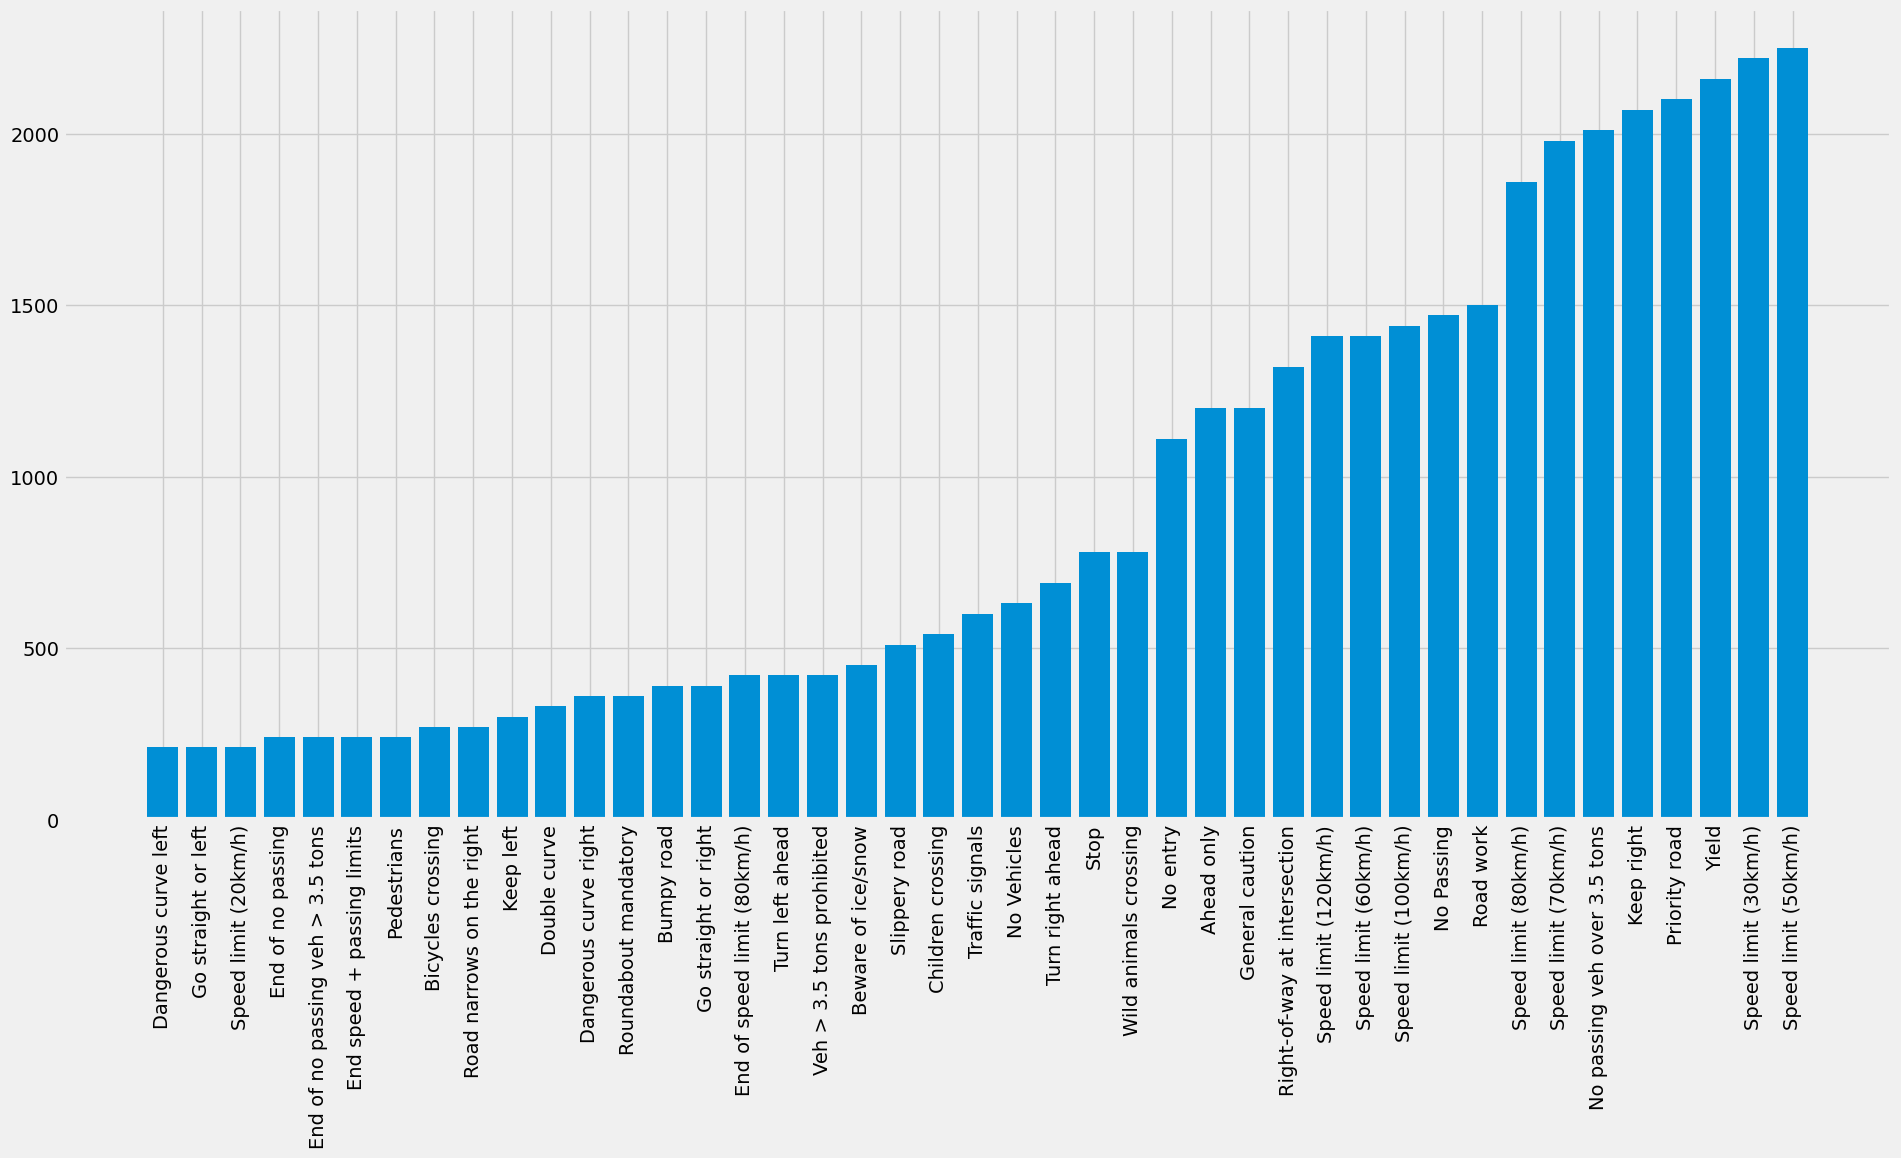

In [19]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
  train_files = os.listdir(train_path + '/' + folder)
  train_number.append(len(train_files))
  class_num.append(classes[int(folder)])

zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in tuples ]

plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

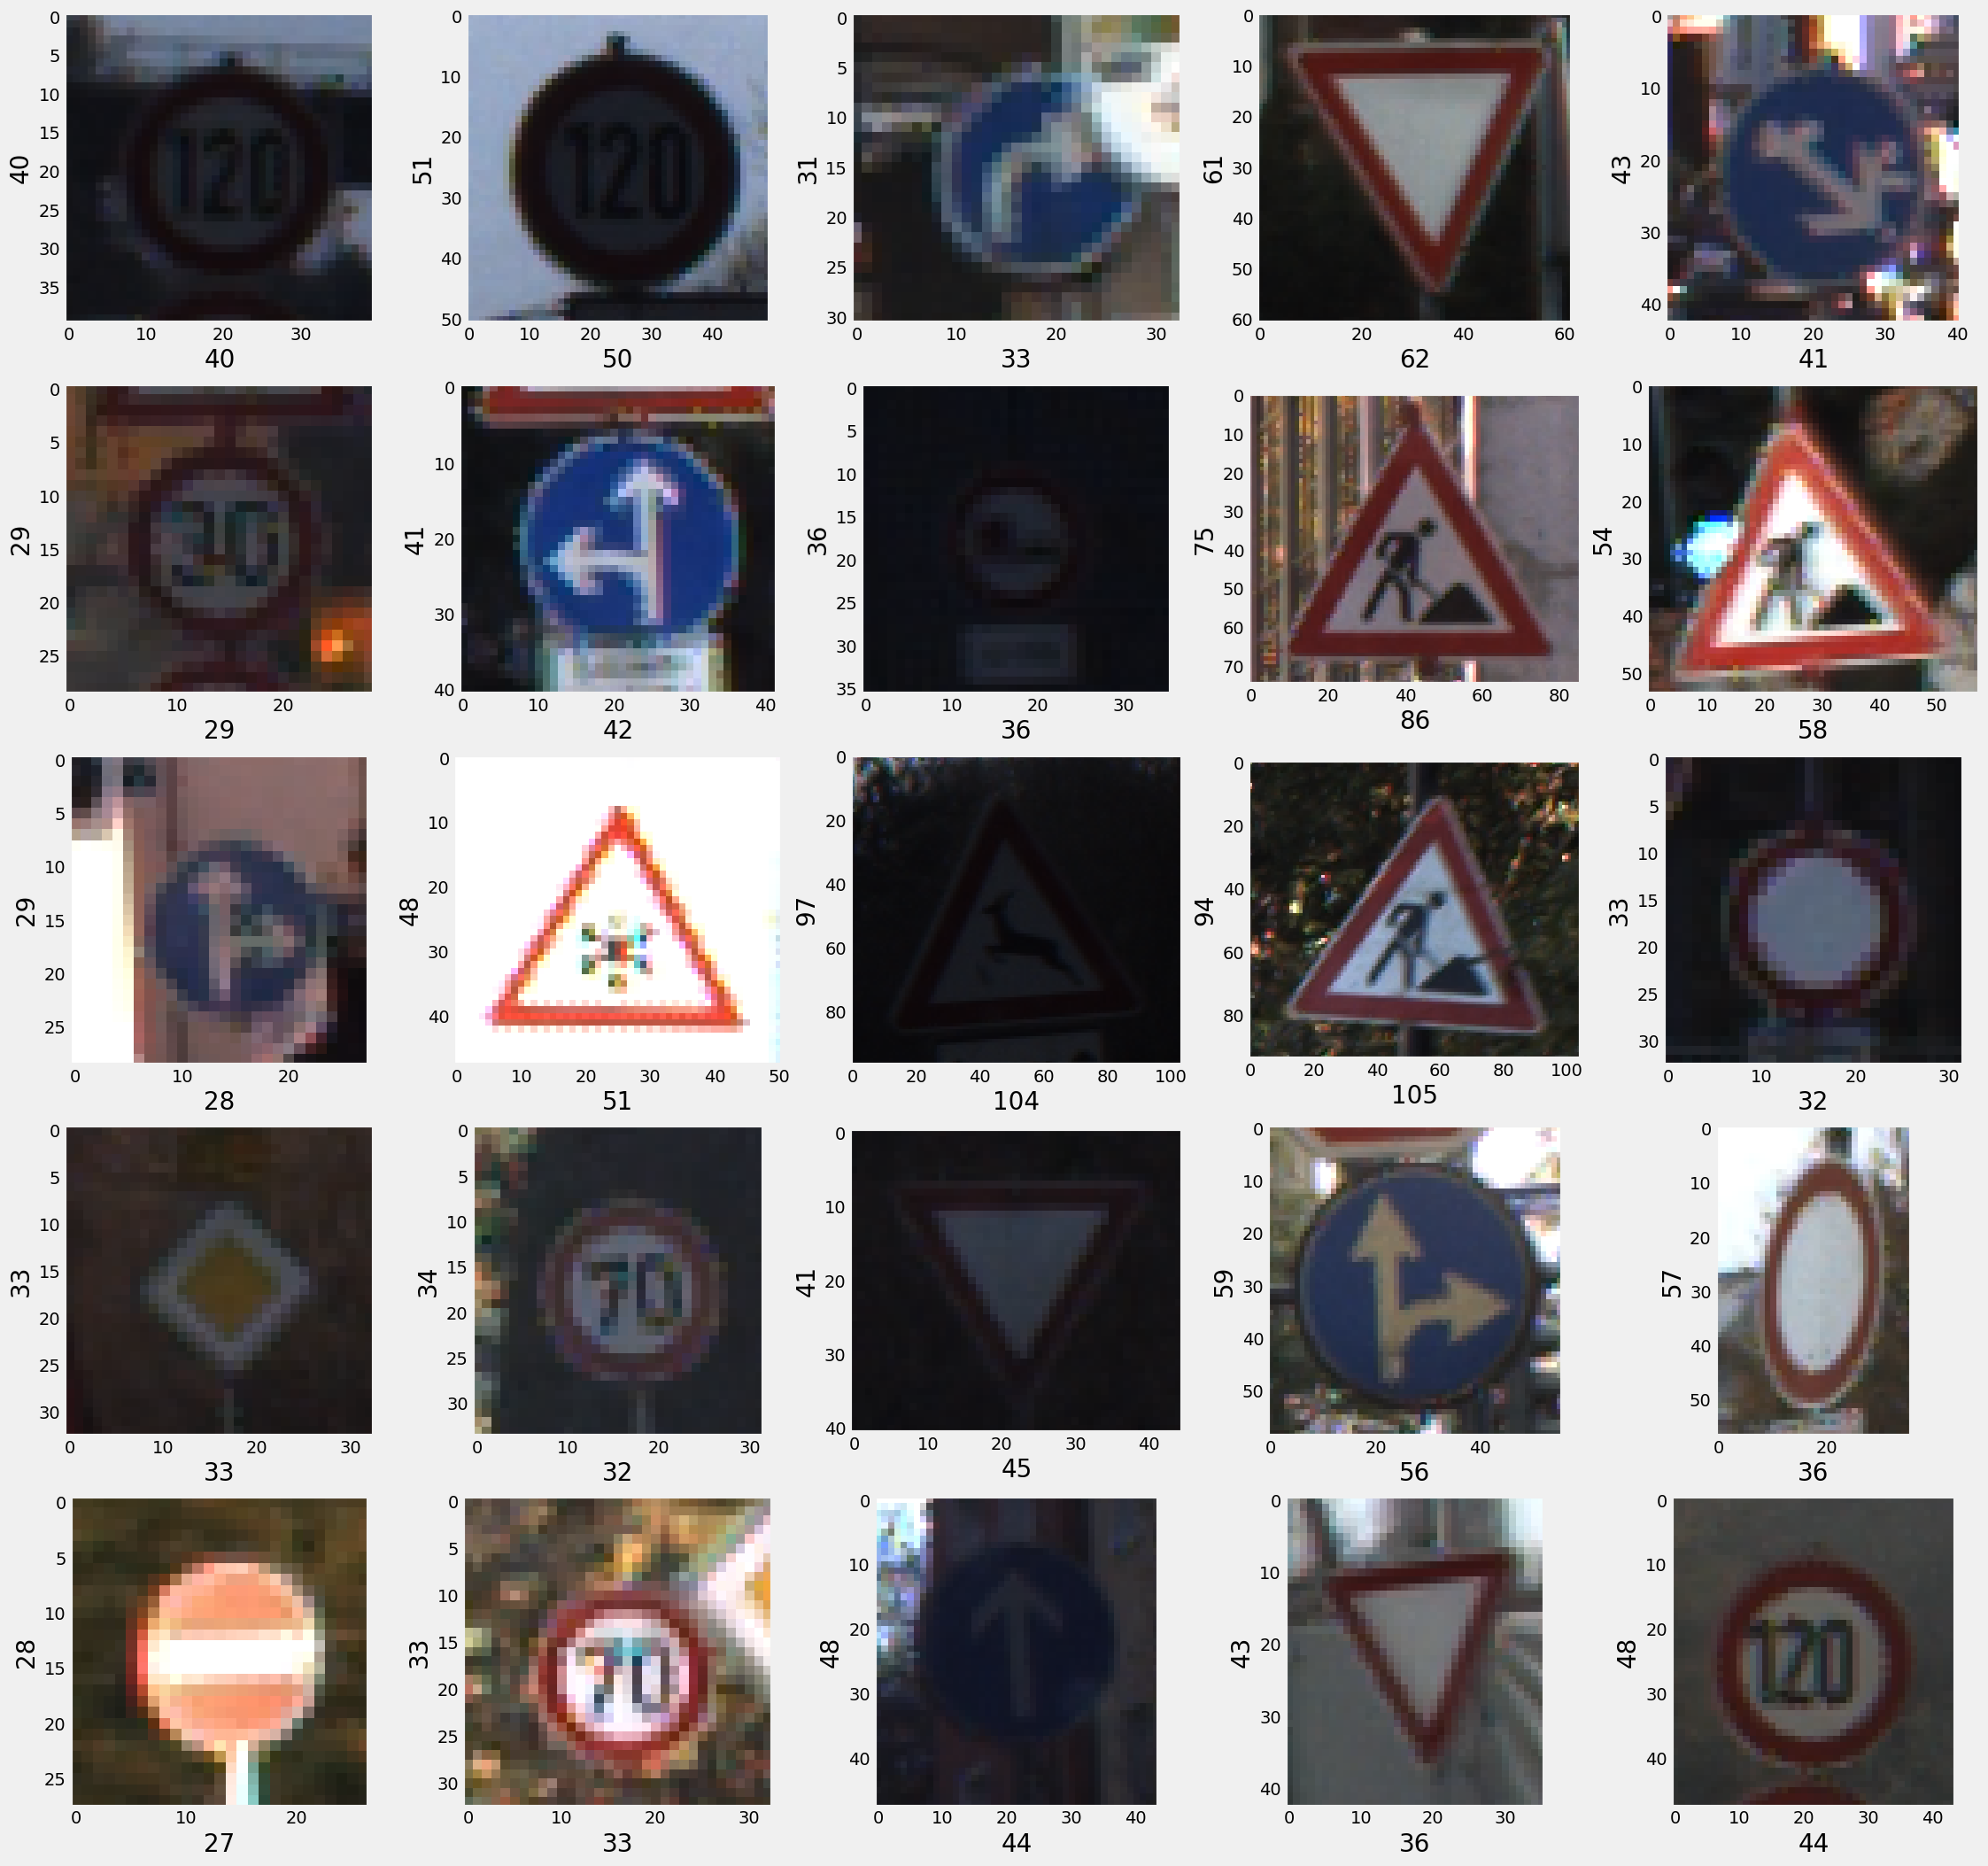

In [23]:
#Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test_csv = "/content/traffic/Test.csv"
test = pd.read_csv(test_csv)
img = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
  plt.subplot(5,5,i)
  random_img_path = "/content/traffic/" + random.choice(img)
  rand_img = imread(random_img_path)
  plt.imshow(rand_img)
  plt.grid(False)
  plt.xlabel(rand_img.shape[1], fontsize = 20)
  plt.ylabel(rand_img.shape[0], fontsize = 20)

Collecting Training Data

In [24]:
image_data = []
image_labels = []

train_root = "/content/traffic/Train"   # <-- correct path

for i in range(NUM_CATEGORIES):
    path = f"{train_root}/{i}"
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(f"{path}/{img}")
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))

            image_data.append(np.array(resize_image))
            image_labels.append(i)

        except:
            print("Error in " + img)

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)


/tmp/ipython-input-1970180771.py:13: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')


(39209, 30, 30, 3) (39209,)


Shuffling Training Data

In [25]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

Splitting data into train and validation set

In [26]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size = 0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


One hot encoding the labels

In [27]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


Making the Model

In [30]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Augmenting the data and training the model

In [33]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 104s 116ms/step - accuracy: 0.4971 - loss: 2.0324 - val_accuracy: 0.9706 - val_loss: 0.1053
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 97s 113ms/step - accuracy: 0.9180 - loss: 0.2597 - val_accuracy: 0.9792 - val_loss: 0.0675
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 99s 115ms/step - accuracy: 0.9546 - loss: 0.1400 - val_accuracy: 0.9703 - val_loss: 0.0854
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 99s 116ms/step - accuracy: 0.9645 - loss: 0.1074 - val_accuracy: 0.9814 - val_loss: 0.0698
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 96s 111ms/step - accuracy: 0.9723 - loss: 0.0873 - val_accuracy: 0.9896 - val_loss: 0.0340
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 98s 114ms/step - accuracy: 0.9736 - loss: 0.0857 - val_accuracy: 0.9927 - val_loss: 0.0243
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 100s 116ms/step - accuracy: 0.9769 - loss: 0.0774 - val_accuracy: 0.9957 - val_loss: 0.0155
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 98s 114ms/step - accuracy: 0.9794 - loss: 0.0643 - v

In [34]:
model.save("model.h5")

Evaluating the model

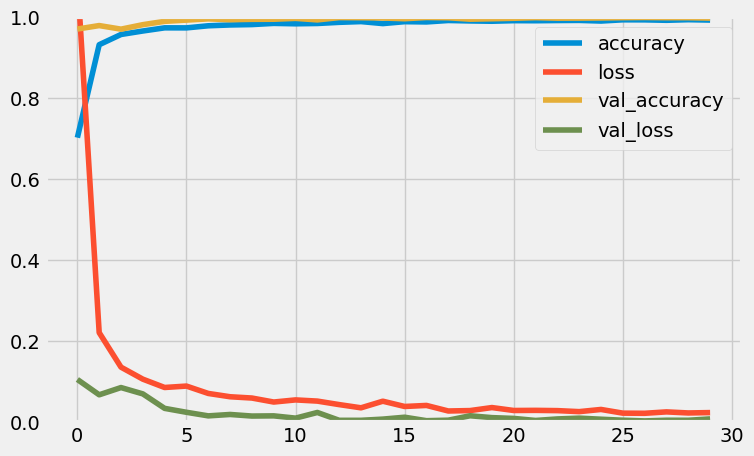

In [35]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Loading test data and running predictions

In [39]:
data_dir = "/content/traffic"     # <-- THIS IS YOUR MAIN DATA FOLDER

# LOADING THE TEST DATA AND RUNNING THE PREDICTIONS
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data=[]

for img in imgs:
  try:
    image = cv2.imread(data_dir + '/' +img)
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
    data.append(np.array(resize_image))
  except:
    print("Erorr in " + img)
X_test = np.array(data)
X_test = X_test/255.0

pred = np.argmax(model.predict(X_test), axis=1)
print('Test Data accuracy: ', accuracy_score(labels, pred)*100)

/tmp/ipython-input-2465045162.py:14: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')


395/395 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step
Test Data accuracy:  97.74346793349169


Classification Report

In [40]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        60
           1       0.99      1.00      1.00       720
           2       0.98      0.98      0.98       750
           3       0.96      0.97      0.97       450
           4       0.99      0.99      0.99       660
           5       0.99      0.97      0.98       630
           6       0.96      0.96      0.96       150
           7       1.00      1.00      1.00       450
           8       1.00      0.99      1.00       450
           9       0.96      1.00      0.98       480
          10       1.00      1.00      1.00       660
          11       0.99      0.97      0.98       420
          12       1.00      0.97      0.99       690
          13       1.00      1.00      1.00       720
          14       0.98      1.00      0.99       270
          15       0.95      1.00      0.97       210
          16       0.99      1.00      1.00       150
          17       1.00    

Predictions on Test Data

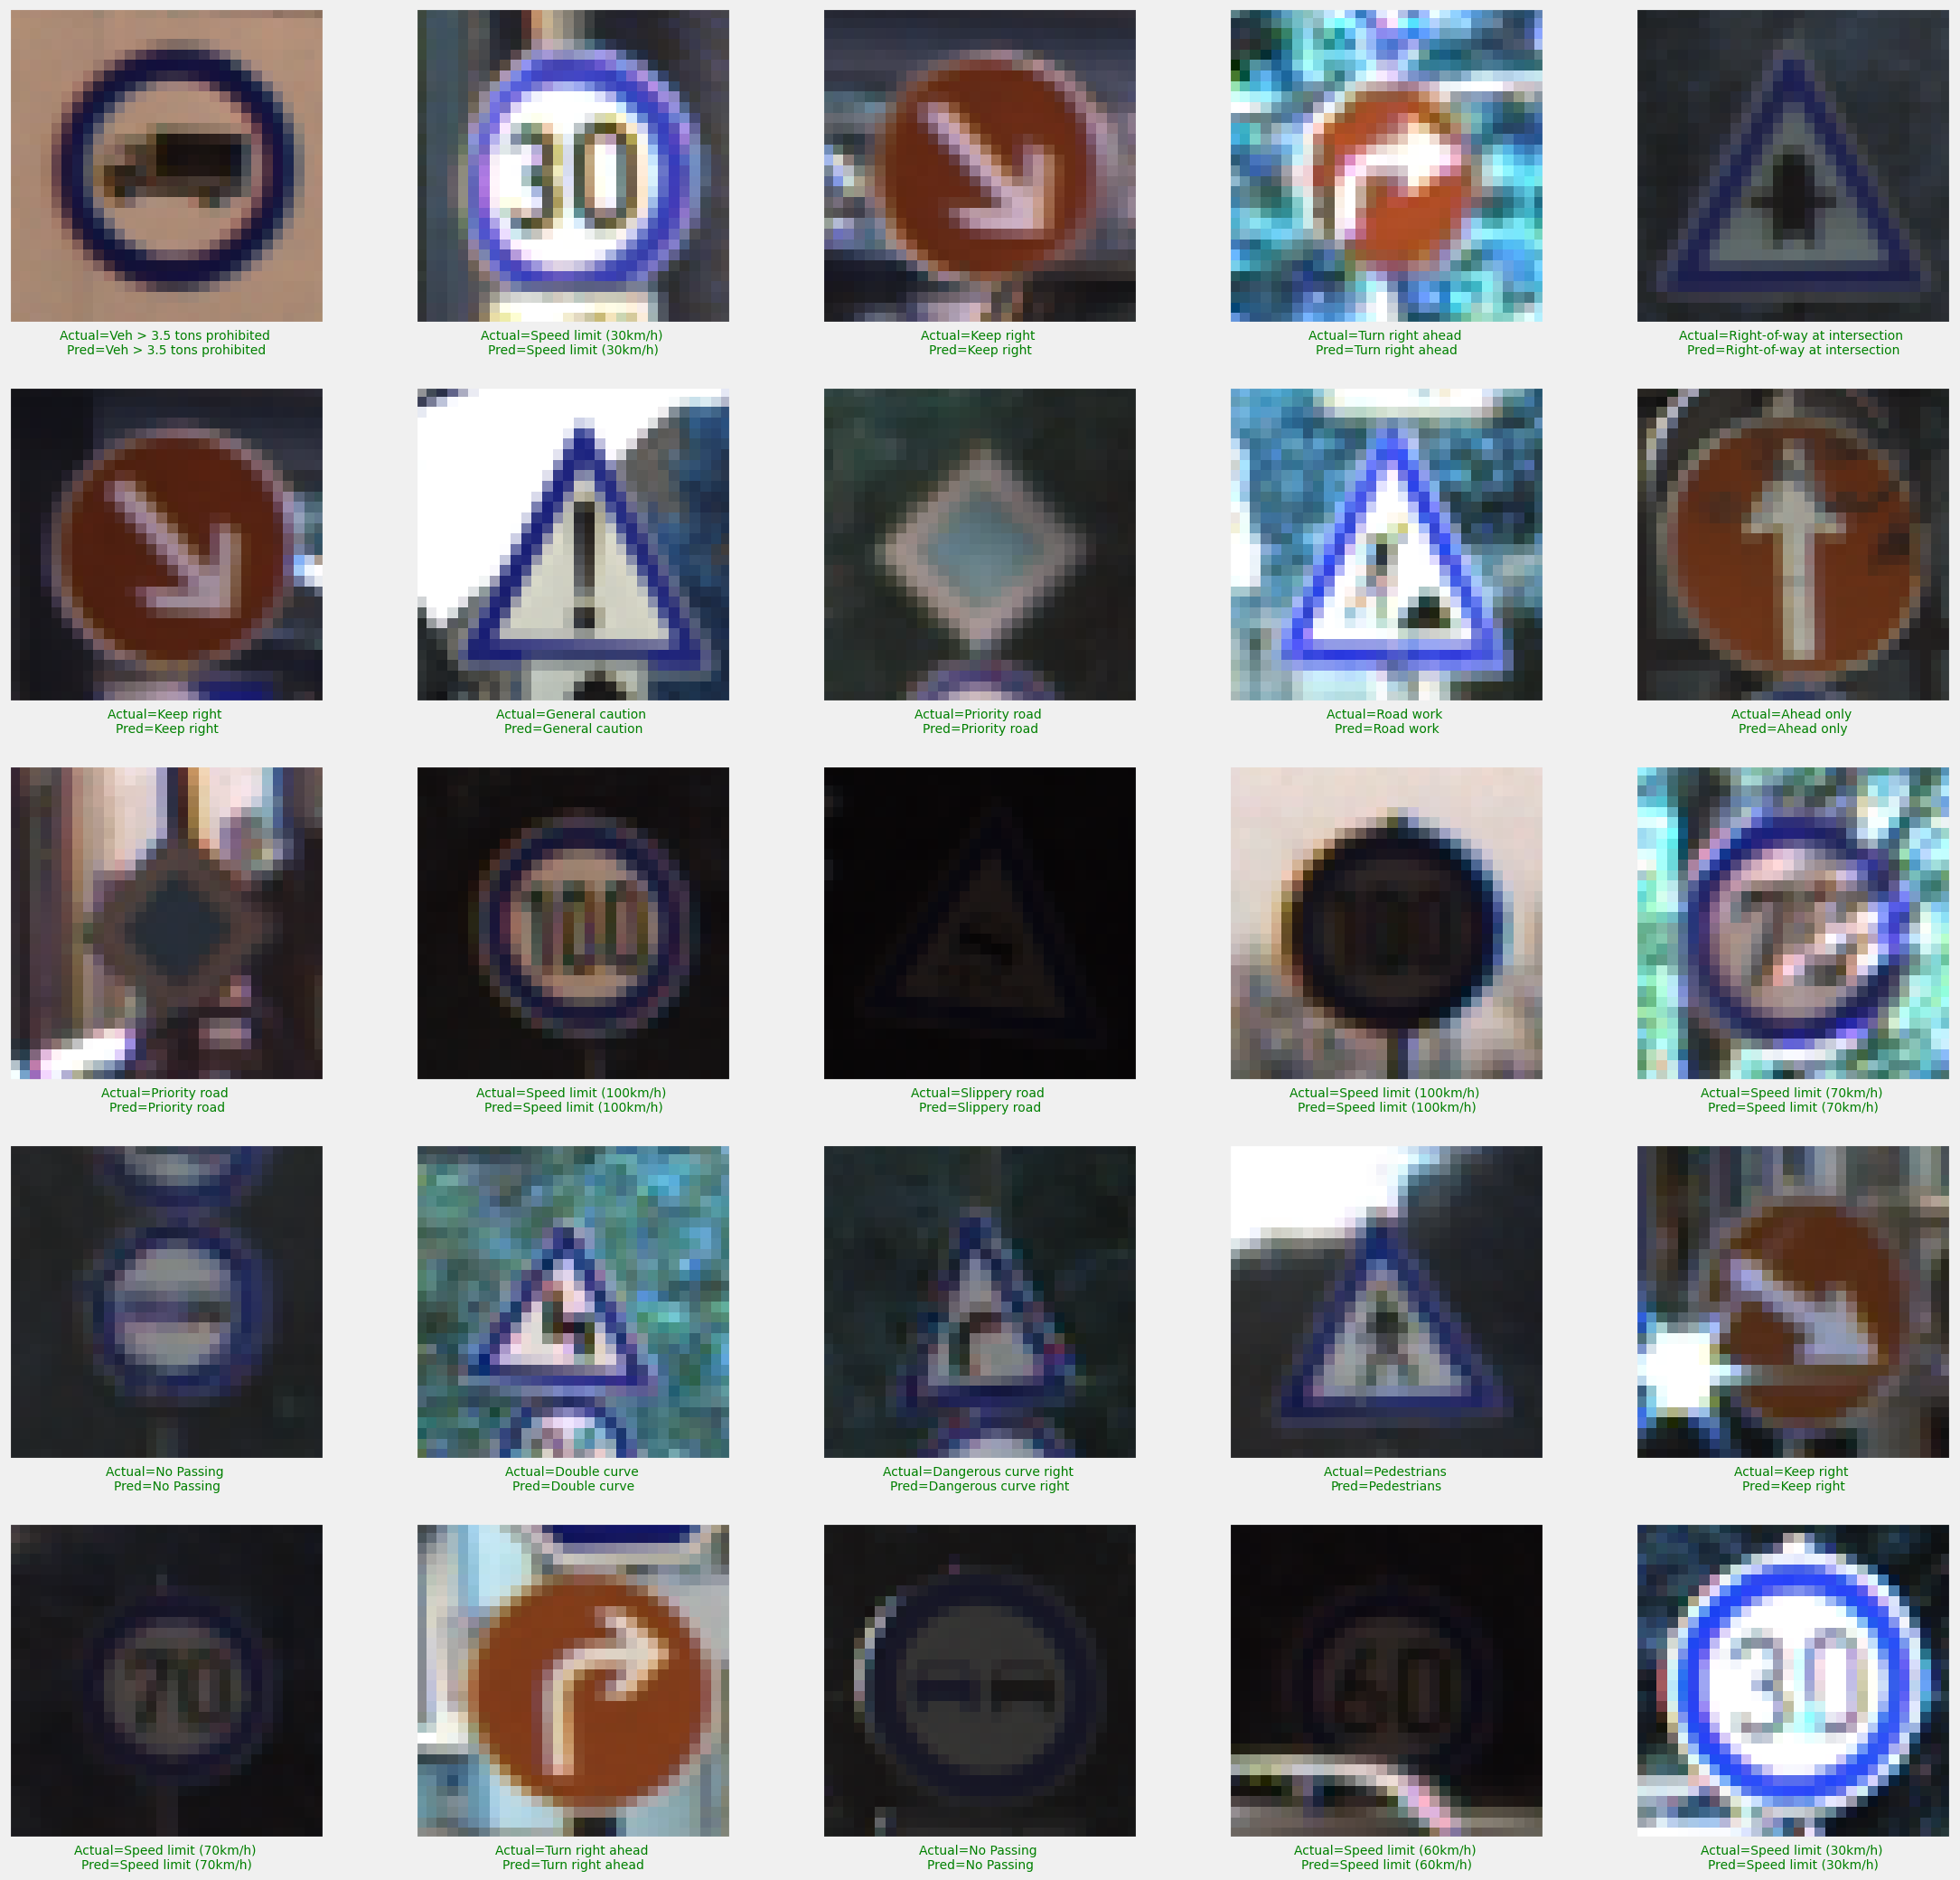

In [42]:
plt.figure(figsize = (25,25))

start_index = 0
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  prediction = pred[start_index + i]
  actual = labels[start_index + i]
  col = 'g'
  if prediction != actual:
    col = 'r'
  plt.xlabel(
    f"Actual={classes[actual]} \nPred={classes[prediction]}",
    color=col,
    fontsize=10
)
  plt.imshow(X_test[start_index + i])
plt.show()